In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
## convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1, dropnan=True, nskip = 0):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    if n_in + n_out == 0:
        return
    # skipped sequences (t + nskip, ... t + n)
    if nskip != 0:
        for j in range(n_vars):
            for i in np.arange(0, n_out, nskip):
                cols.append(df.iloc[:,j].shift(-i))
                names += [('{}{}(t+{})'.format(df.columns[0], j+1, i))]
    # regular sequences
    else:
        # input sequence (t-n, ... t-1)
        for j in range(n_vars):
            for i in range(n_in, 0, -1):
                cols.append(df.iloc[:,j].shift(i))
                names.append('{}{}(t-{})'.format(df.columns[0], j+1, i))

        # forecast sequence (t+1, ... t+n)
        for j in range(n_vars):
            for i in range(0, n_out):
                cols.append(df.iloc[:,j].shift(-i))
                names += [('{}{}(t+{})'.format(df.columns[0], j+1, i))]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}".format(name), row, True) 
        i += 1
    return plot_df

def get_eval(y, yhat):
    print("MSE: {}".format(mean_squared_error(y,yhat)))
    print("MAE: {}".format(mean_absolute_error(y,yhat)))
    print("r2_score: {}".format(r2_score(y,yhat, multioutput = "variance_weighted")))
    
## feature/ target construction fucntion with lag variable
def feature_target_construct(df, load_lag, target_ahead, temp_ahead, tskip = 0, wd_on = False):
    tempcols = ['temperature']
    load = df['energy']
    f_temp = pd.DataFrame()
    
    ## temp ahead series
    for col in tempcols:
        if(tskip != 0):
            temp = lag_ahead_series(df[col], 
                                 n_in = 0,
                                 n_out = temp_ahead,
                                 n_vars = 1,
                                 dropnan = True,
                                 nskip= tskip)
        else:
             temp = lag_ahead_series(df[col], 
                                 n_in = 0,
                                 n_out = temp_ahead,
                                 n_vars = 1,
                                 dropnan = True)
        f_temp = pd.concat([f_temp, temp], axis = 1)            
        
    ## load lag series
    f_load = lag_ahead_series(load,
                          n_in = load_lag,
                          n_out = 0,
                          n_vars = 1,
                          dropnan = True)
    # when f_temp exist
    if f_temp.shape[1] > 0:
        f_load, f_temp = f_load.align(f_temp, 'inner', axis = 0)
        f = pd.concat([f_temp, f_load], axis = 1)
    # when no f_temp
    else:
        f = f_load
        
    ## weekday on
    if wd_on:
        # weekday one hot encoding
        weekday = pd.get_dummies(df.iloc[:,-1])
        # alignment
        weekday , f = weekday.align(f, 'inner', axis = 0)
        f = pd.concat([weekday, f], axis = 1)
        
    ## number of LCLid on                  
    if('LCLid' in df.columns):
        nlclid = df['LCLid']
        # alignment
        nlclid, f = nlclid.align(f, 'inner', axis = 0)       
        f = pd.concat([f, nlclid], axis = 1)
        
        
    ## target part
    t = lag_ahead_series(load,
                          n_in = 0,
                          n_out = target_ahead,
                          n_vars = 1,
                          dropnan = True)
    # alignment of feature and target
    f, t = f.align(t, 'inner', axis = 0)
    
    return f, t

In [3]:
train = pd.read_csv("../data/train_nocat_hh.csv", index_col= 'tstp')
test = pd.read_csv("../data/test_nocat_hh.csv", index_col= 'tstp')

## Ahead for temperature, lag for energy, weekdays encoding

In [5]:
ftrain, ttrain = feature_target_construct(train, 48, 48, 48, 4, wd_on = True)
ftest, ttest = feature_target_construct(test, 48, 48, 48, 4, wd_on = True)

### Full dataset: Time series split

In [11]:
from tpot import TPOTRegressor
from tpot_mulr import mul_reg_config_dict
from sklearn.model_selection import TimeSeriesSplit
#import mul_config as mc

tpot_reg = TPOTRegressor(generations=20, population_size=15,
                         offspring_size=None, mutation_rate=0.9,
                         crossover_rate=0.1,
                         scoring='neg_mean_squared_error', 
                         cv= TimeSeriesSplit(n_splits = 10),
                         subsample=1, 
                         n_jobs=4,
                         max_time_mins=180, max_eval_time_mins=15,
                         random_state=1, 
                         config_dict=mul_reg_config_dict,
                         template=None,
                         warm_start=True,
                         memory=None,
                         use_dask=False,
                         periodic_checkpoint_folder=None,
                         early_stop=None,
                         verbosity=2,
                         disable_update_check=False)
tpot_reg.fit(ftrain, ttrain)

Generation 1 - Current best internal CV score: -32541.229041113325
Generation 2 - Current best internal CV score: -32541.229041113325
Generation 3 - Current best internal CV score: -32541.229041113325
Generation 4 - Current best internal CV score: -32541.229041113325
Generation 5 - Current best internal CV score: -32541.229041113325
Generation 6 - Current best internal CV score: -32000.384655600075
Generation 7 - Current best internal CV score: -32000.384655600075
Generation 8 - Current best internal CV score: -32000.384655600075
Generation 9 - Current best internal CV score: -31719.949027368537
Generation 10 - Current best internal CV score: -31719.949027368537
Generation 11 - Current best internal CV score: -31719.949027368537
Generation 12 - Current best internal CV score: -31220.377315867616
Generation 13 - Current best internal CV score: -31220.377315867616
Generation 14 - Current best internal CV score: -31220.377315867616

181.01 minutes have elapsed. TPOT will close down.
TPOT 

TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

### TPOT: 24 hour ahead, half-hourly

In [12]:
#val_X, val_y = train.iloc[500:600,:8], ahead_e.iloc[500:600,:]
yhat = tpot_reg.predict(ftest)

In [13]:
get_eval(ttest.iloc[:1,:49].to_numpy().reshape(-1,1), yhat[:1,:49].reshape(-1,1))

MSE: 14966.983547016498
MAE: 92.41720754617957
r2_score: 0.9130700609738939


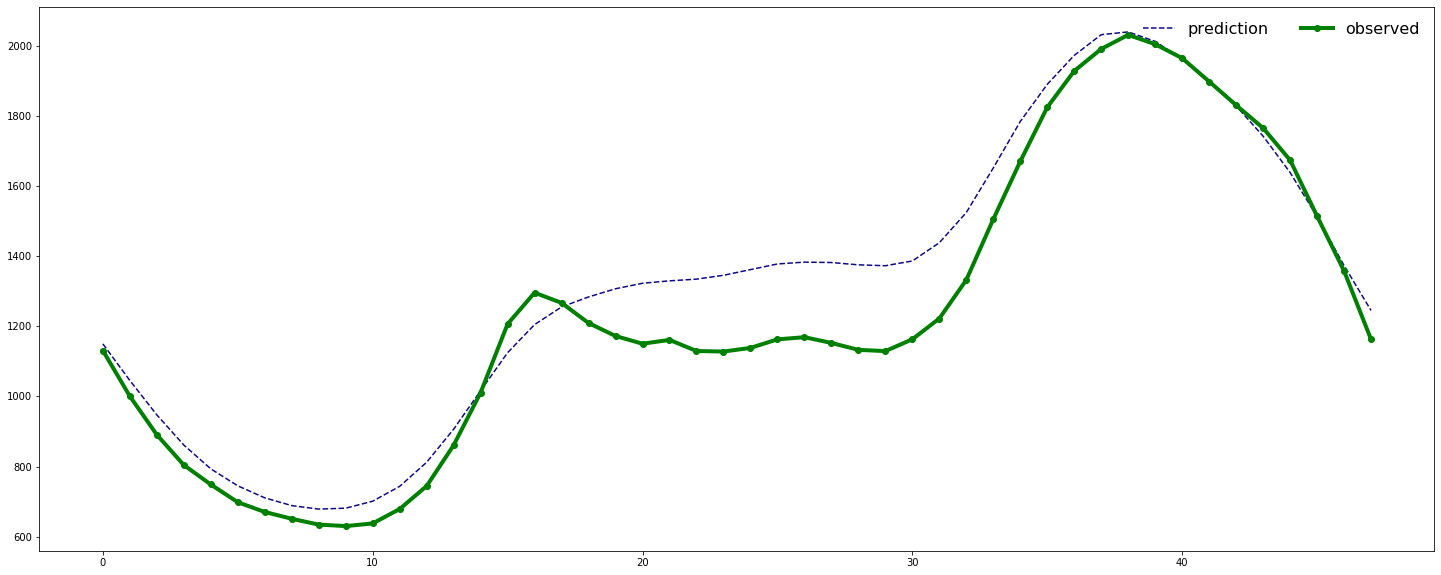

In [14]:
## assignment
real = ttest.to_numpy()
guess = yhat
real = real[0:1,:49]
guess = guess[0:1,:49]
rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

### Subsample 0.2:  Shuffle Splits

In [ ]:
from sklearn.model_selection import ShuffleSplit
#import mul_config as mc

tpot_reg = TPOTRegressor(generations=20, population_size=15,
                         offspring_size=None, mutation_rate=0.9,
                         crossover_rate=0.1,
                         scoring='neg_mean_squared_error', 
                         cv= ShuffleSplit(n_splits = 10, test_size = 0.3),
                         subsample=0.2, 
                         n_jobs=4,
                         max_time_mins=180, max_eval_time_mins=15,
                         random_state=1, 
                         config_dict=mul_reg_config_dict,
                         template=None,
                         warm_start=True,
                         memory=None,
                         use_dask=False,
                         periodic_checkpoint_folder=None,
                         early_stop=None,
                         verbosity=2,
                         disable_update_check=False)
tpot_reg.fit(ftrain, ttrain)

In [13]:
#val_X, val_y = train.iloc[500:600,:8], ahead_e.iloc[500:600,:]
yhat = tpot_reg.predict(test_X)

### Result Evaluation

**Mean Square Error**

In [14]:
mean_squared_error(test_y, yhat)

0.00032078067403312787

**Mean Absolute Error**

In [15]:
mean_absolute_error(test_y, yhat)

0.01406389608671403

**R2_score**

In [16]:
r2_score(test_y, yhat)

0.8304769005992318

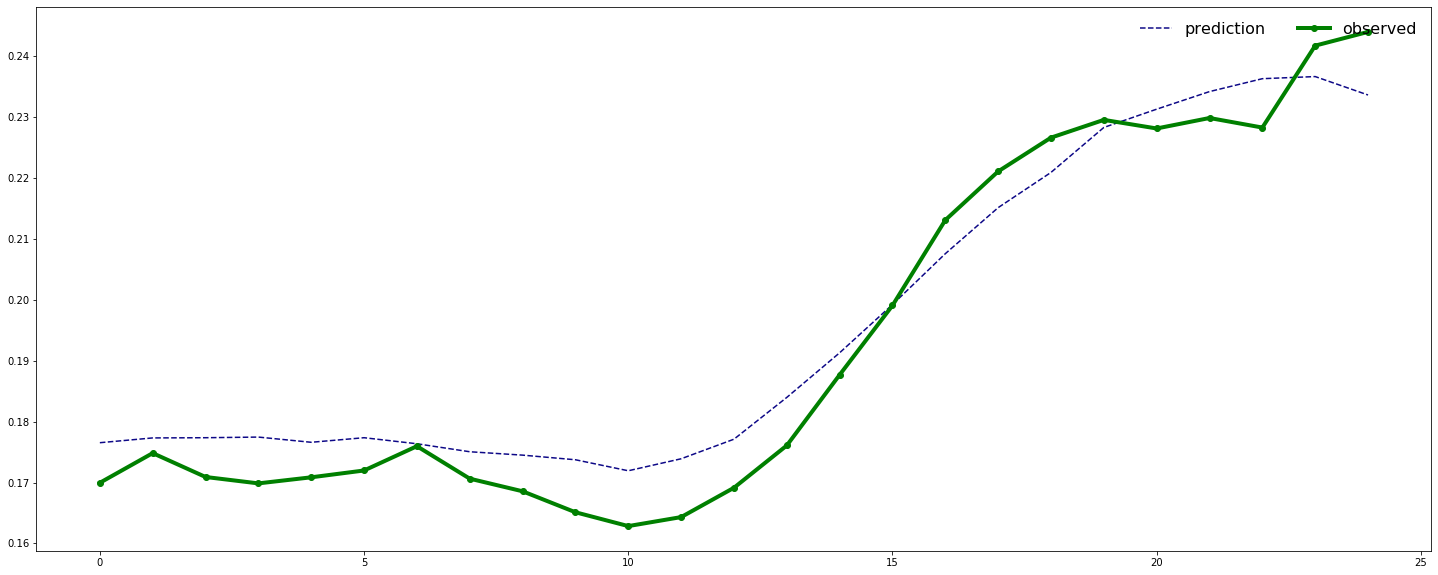

In [18]:
## assignment
real = test_y.to_numpy()
guess = yhat
real = real[50:51,:49]
guess = guess[50:51,:49]
rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

### TPOT: 24 hour ahead, half-hourly

In [7]:
from tpot import TPOTRegressor
from tpot_mulr import mul_reg_config_dict
from sklearn.model_selection import train_test_split
#import mul_config as mc

train_X, val_X, train_y, val_y = train_test_split(ahead_w, ahead_e, train_size = 0.05, test_size = 0.95, random_state = 123)

tpot_reg = TPOTRegressor(generations=30, 
                         population_size=60, 
                         n_jobs=4, 
                         verbosity=2, 
                         random_state=123,
                         subsample= 0.8,
                         config_dict=mul_reg_config_dict)
tpot_reg.fit(train_X , train_y)


Generation 1 - Current best internal CV score: -0.002535817417579815
Generation 2 - Current best internal CV score: -0.002530690697956506
Generation 3 - Current best internal CV score: -0.002530690697956506
Generation 4 - Current best internal CV score: -0.002510051020902841
Generation 5 - Current best internal CV score: -0.002510051020902841
Generation 6 - Current best internal CV score: -0.002510051020902841
Generation 7 - Current best internal CV score: -0.002491375270707632
Generation 8 - Current best internal CV score: -0.0024314059283892667
Generation 9 - Current best internal CV score: -0.0023766470404857337
Generation 10 - Current best internal CV score: -0.0023766470404857337
Generation 11 - Current best internal CV score: -0.0023766470404857337
Generation 12 - Current best internal CV score: -0.0023766470404857337
Generation 13 - Current best internal CV score: -0.002355760607122987
Generation 14 - Current best internal CV score: -0.002355760607122987
Generation 15 - Current 

TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

In [8]:
yhat = tpot_reg.predict(test_X)
mean_squared_error(test_y, yhat)
mean_absolute_error(test_y, yhat)
r2_score(test_y, yhat)

0.8708304000147385

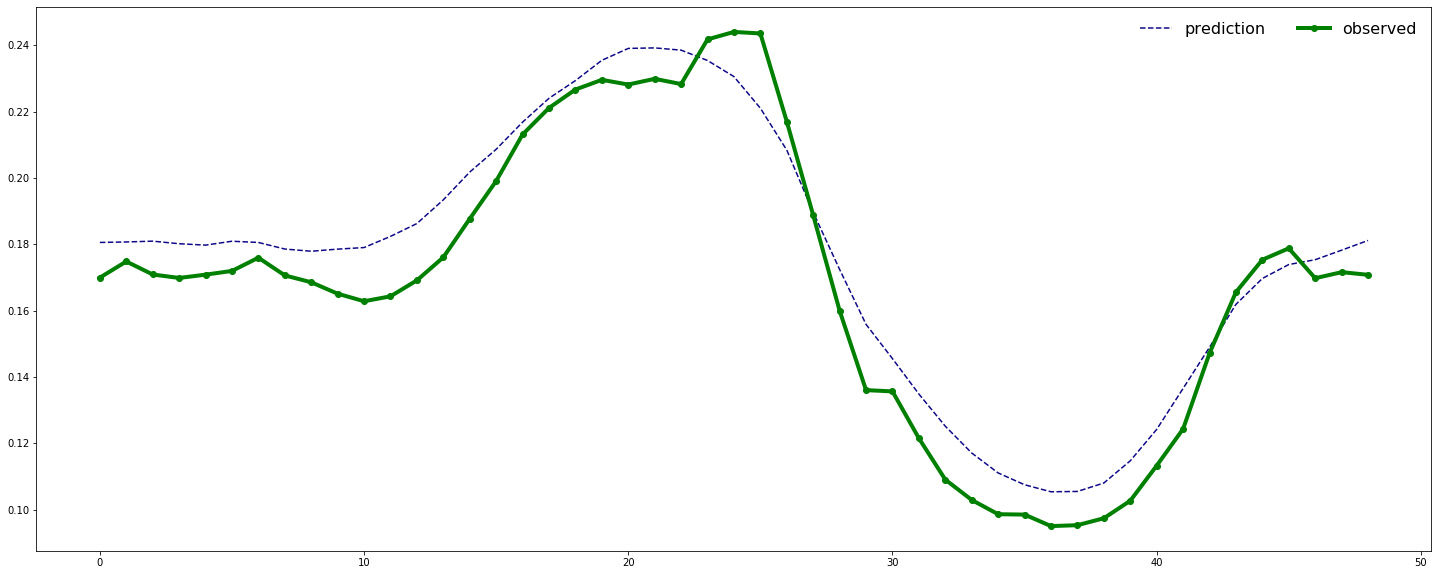

In [9]:
## assignment
real = test_y.to_numpy()
guess = yhat
real = real[50:51,:49]
guess = guess[50:51,:49]
rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()